In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Data Processing

The majority of the code follows the provided template code in the [Competition's Train Demo Notebook](https://www.kaggle.com/code/smeitoma/train-demo/notebook), but this notebook uses an **LSTM model** to make stock price predictions instead of the Demo's LGBM model.

The following functions are used to adjust the close prices in the raw stock price data.

In [ ]:
from decimal import ROUND_HALF_UP, Decimal

def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

We import the code necessary for the LSTM Model.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.optimizers import Adam

We load the data, adjust closing prices, and view the resulting data.

In [ ]:
# Load stock price data
df_price = pd.read_csv("stock_prices.csv")

# df_supp =  pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")

In [ ]:
df_price = adjust_price(df_price)
# df_supp = adjust_price(df_supp)
df_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 13 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   RowId                       object 
 1   SecuritiesCode              int64  
 2   Open                        float64
 3   High                        float64
 4   Low                         float64
 5   Close                       float64
 6   Volume                      int64  
 7   AdjustmentFactor            float64
 8   ExpectedDividend            float64
 9   SupervisionFlag             bool   
 10  Target                      float64
 11  CumulativeAdjustmentFactor  float64
 12  AdjustedClose               float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 233.6+ MB


In [ ]:
display(df_price.head(2))
display(df_price.tail(2))

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,AdjustedClose
Date,,,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.00073,1.0,2742.0
2017-01-05,20170105_1301,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.00292,1.0,2738.0


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,AdjustedClose
Date,,,,,,,,,,,,,
2021-12-02,20211202_9997,9997,681.0,692.0,680.0,684.0,342900,1.0,NaN,False,0.014368,1.0,684.0
2021-12-03,20211203_9997,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414,1.0,696.0


The following function represents **Feature Engineering**, and we can use this to set features for the stock price data.

In [ ]:
def get_features_for_predict(price, code):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
        code (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    close_col = "AdjustedClose"
    feats = price.loc[price["SecuritiesCode"] == code, ["SecuritiesCode",
      close_col, "ExpectedDividend", "High", "Low", "Open", "Close"]].copy()

    # single case
    feats["return_1day"] = feats[close_col].pct_change(1)

    # Amplitude
    feats["Amplitude"] = feats["High"] - feats["Low"]

    # Open to Close
    feats["OpentoClose"] = feats["Open"] - feats["Close"]

    # 52 Week High
    High52 = feats['AdjustedClose']/feats['High'].rolling(250).max()
    High52.rename('High52',inplace = True)
    feats = feats.merge(High52,left_index = True,right_index = True, how = 'left')

    # MACD
    feats["MACD"] = feats[close_col].ewm(span=12, adjust=False).mean() - feats[close_col].ewm(span=26, adjust=False).mean()

    for period in [5, 10, 20, 40, 60]:

      # calculate return using AdjustedClose
      feats["return_{}day".format(period)] = feats[close_col].pct_change(period)

      # volatility
      feats["volatility_{}day".format(period)] = np.log(feats[close_col]).diff().rolling(period).std()

      # moving average
      feats["MA_{}day".format(period)] = feats[close_col].rolling(period).mean()

      # exponential moving average
      feats["EMA_{}day".format(period)] = feats[close_col].ewm(span=period, adjust=False).mean()

      # ExpectedDividend
      feats["ExpectedDividend_{}".format(period)] = feats["ExpectedDividend"].mask(feats["ExpectedDividend"] / feats[close_col] > period / 500, 1)

      # RSI
      C_Diff = feats['AdjustedClose'] - feats['AdjustedClose'].shift(1)
      U = C_Diff.apply(lambda series: series if series > 0 else 0)
      D = C_Diff.apply(lambda series: -series if series < 0 else 0)
      EMA_U = U.ewm(span = period, adjust = False).mean()
      EMA_D = D.ewm(span = period, adjust = False).mean()
      RSI = EMA_U/(EMA_U+EMA_D) * 100
      RSI.rename('RSI_{}day'.format(period),inplace = True)
      feats = feats.merge(RSI,left_index = True,right_index = True,how = 'left')

      # MACD
      feats["MACD_{}day".format(period)] = feats[close_col].ewm(span=period,
        adjust=False).mean() - feats[close_col].ewm(span=2*period, adjust=False).mean()

      # BIAS
      BIAS = feats['AdjustedClose'].rolling(period).mean()
      BIAS = (feats['AdjustedClose'] - BIAS)/BIAS
      BIAS.rename('BIAS_{}day'.format(period),inplace = True)
      feats = feats.merge(BIAS,left_index = True,right_index = True, how = 'left')

    # filling data for nan and inf
    feats = feats.fillna(0)
    feats = feats.replace([np.inf, -np.inf], 0)
    # drop AdjustedClose column
    feats = feats.drop([close_col], axis=1)

    return feats

In [ ]:
# fetch prediction target SecuritiesCodes
# There are 2000 codes
codes = sorted(df_price["SecuritiesCode"].unique())
len(codes)

2000

In [ ]:
from tqdm import tqdm
# generate the features for prediction
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(df_price, code)
    buff.append(feat)
feature = pd.concat(buff)

100%|██████████| 2000/2000 [02:50<00:00, 11.71it/s]


In [ ]:
display(feature.head(2))
display(feature.tail(2))

,SecuritiesCode,ExpectedDividend,High,Low,Open,Close,return_1day,Amplitude,OpentoClose,High52,...,MACD_40day,BIAS_40day,return_60day,volatility_60day,MA_60day,EMA_60day,ExpectedDividend_60,RSI_60day,MACD_60day,BIAS_60day
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,1301,0.0,2755.0,2730.0,2734.0,2742.0,0.000000,25.0,-8.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,2742.000000,0.0,0.0,0.000000,0.0
2017-01-05,1301,0.0,2747.0,2735.0,2743.0,2738.0,-0.001459,12.0,5.0,0.0,...,-0.096357,0.0,0.0,0.0,0.0,2741.868852,0.0,0.0,-0.065032,0.0


,SecuritiesCode,ExpectedDividend,High,Low,Open,Close,return_1day,Amplitude,OpentoClose,High52,...,MACD_40day,BIAS_40day,return_60day,volatility_60day,MA_60day,EMA_60day,ExpectedDividend_60,RSI_60day,MACD_60day,BIAS_60day
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-02,9997,0.0,692.0,680.0,681.0,684.0,-0.001460,12.0,-3.0,0.506292,...,-54.122108,-0.111284,-0.206497,0.013802,799.333333,785.312539,0.0,31.289117,-67.940654,-0.144287
2021-12-03,9997,0.0,711.0,686.0,690.0,696.0,0.017544,25.0,-6.0,0.515174,...,-54.254605,-0.092006,-0.195376,0.014042,796.516667,782.384259,0.0,34.205419,-68.269707,-0.126195


In [ ]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 51 columns):
 #   Column               Dtype  
---  ------               -----  
 0   SecuritiesCode       int64  
 1   ExpectedDividend     float64
 2   High                 float64
 3   Low                  float64
 4   Open                 float64
 5   Close                float64
 6   return_1day          float64
 7   Amplitude            float64
 8   OpentoClose          float64
 9   High52               float64
 10  MACD                 float64
 11  return_5day          float64
 12  volatility_5day      float64
 13  MA_5day              float64
 14  EMA_5day             float64
 15  ExpectedDividend_5   float64
 16  RSI_5day             float64
 17  MACD_5day            float64
 18  BIAS_5day            float64
 19  return_10day         float64
 20  volatility_10day     float64
 21  MA_10day             float64
 22  EMA_10day            float64
 23  ExpectedDividend_

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

Run PCA and see importance of components

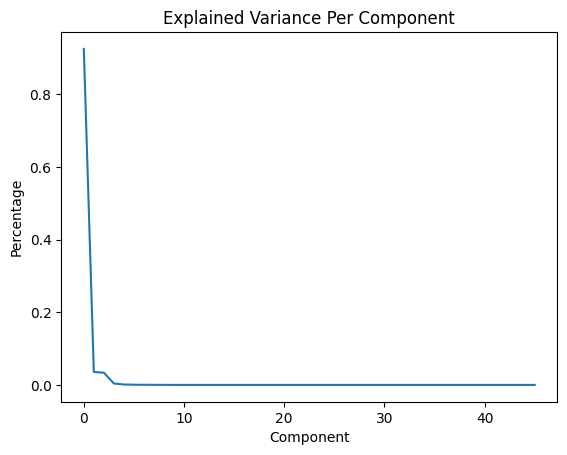

In [ ]:
pca = PCA(n_components = 'mle')
pca.fit(feature)
fig, ax = plt.subplots(1)
plt.title("Explained Variance Per Component")
plt.ylabel("Percentage")
plt.xlabel("Component")
ax.plot(pca.explained_variance_ratio_)

First three components account for 99% of variance

In [ ]:
sum(pca.explained_variance_ratio_[:3])

0.9934308669125032

Return60, MACD10, return40, volatility60, and Bias10 have large impact in first two columns

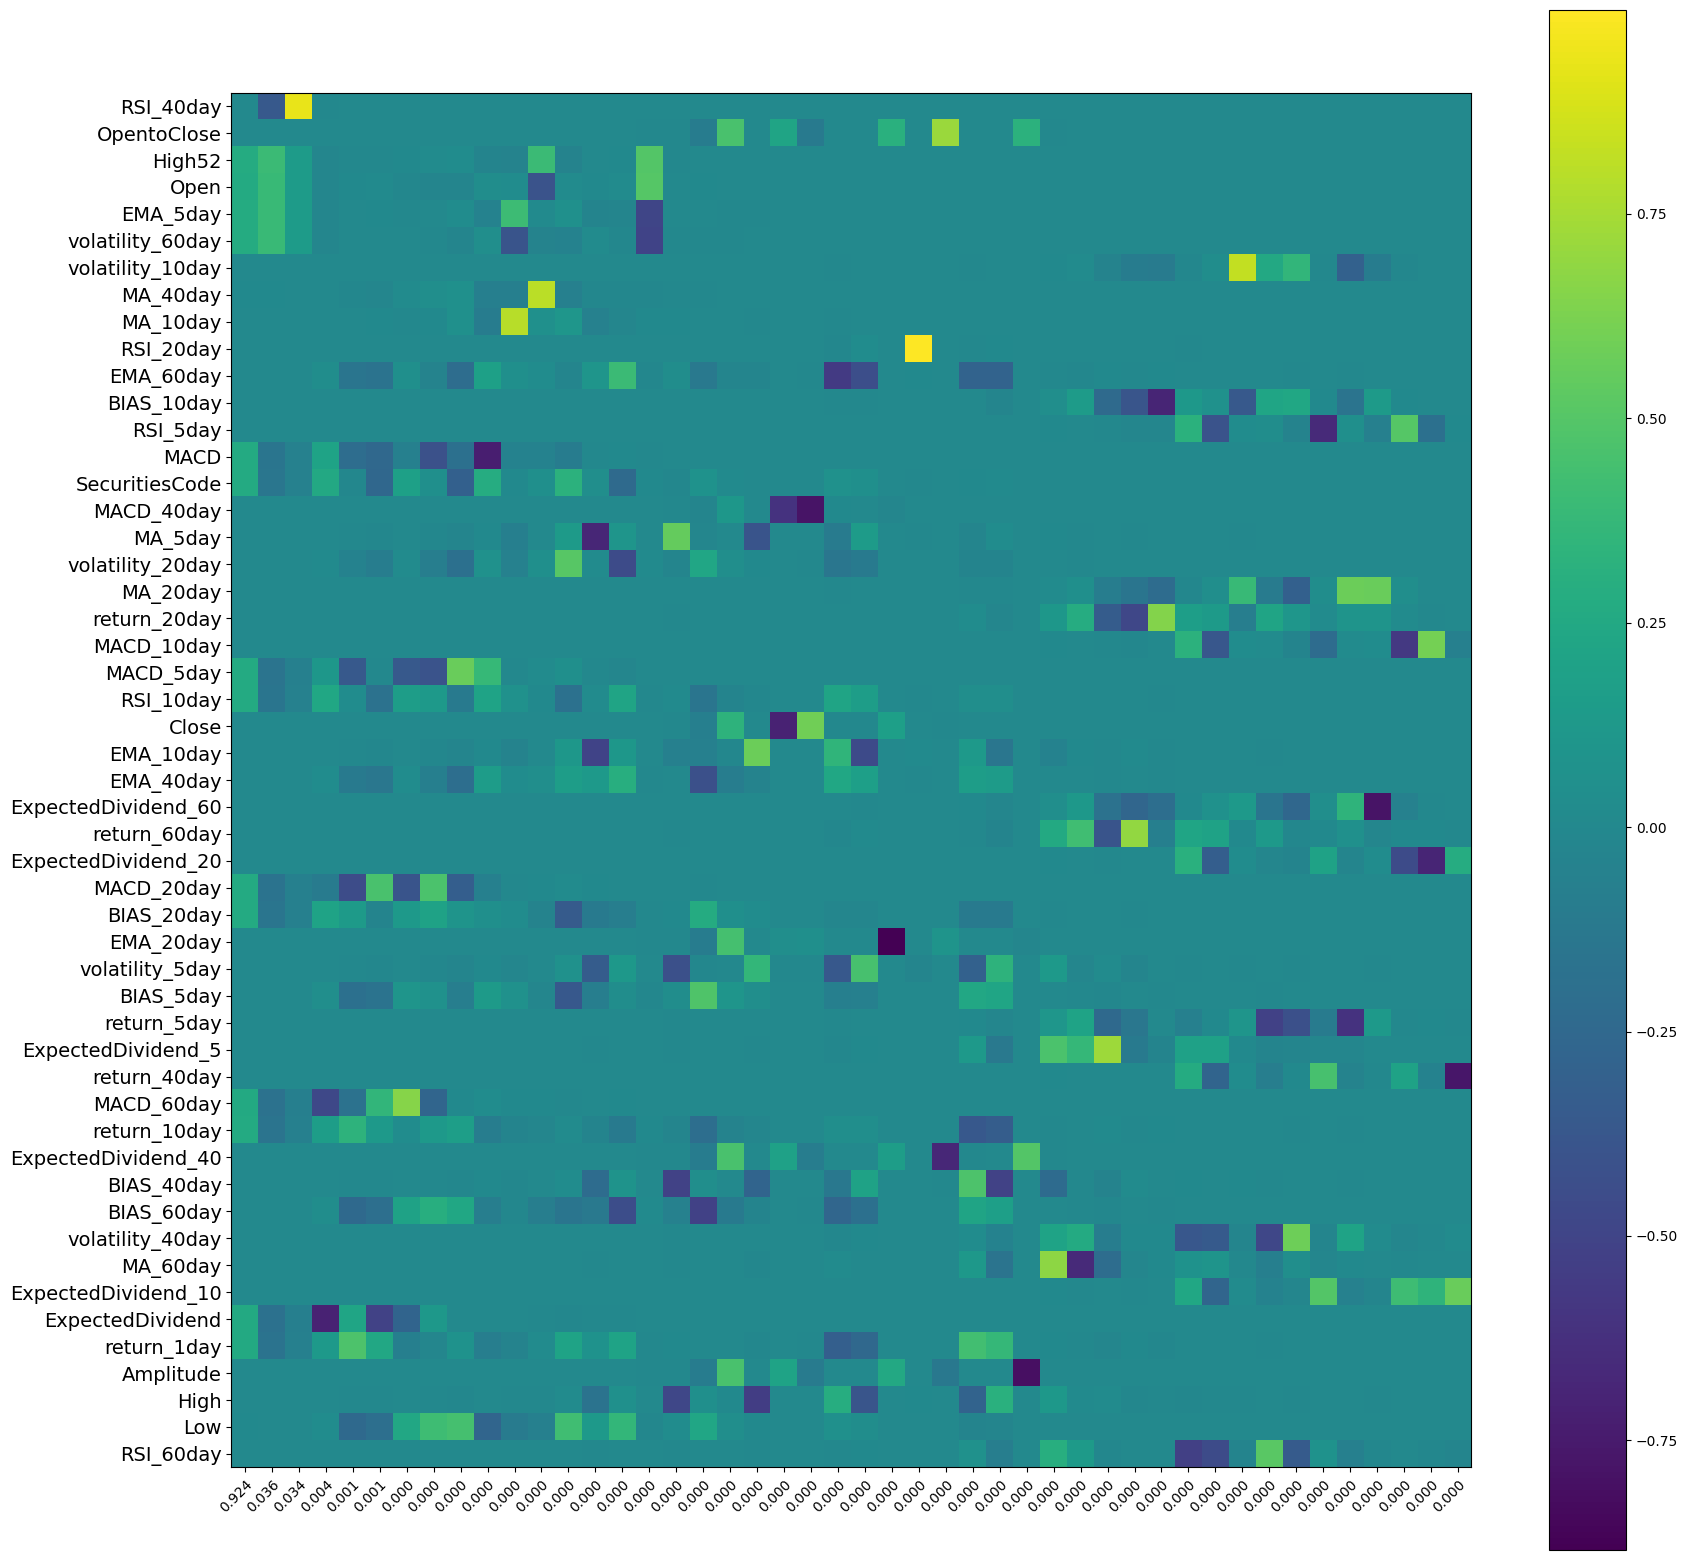

In [ ]:
feature_copy = feature.copy()
feature_copy[['Component_A', 'Component_B', 'Component_C']] = pca.transform(feature_copy)[:,0:3]

original_features = list(set(feature_copy.columns) - set(['Component_A', 'Component_B', 'Component_C']))
fig, ax = plt.subplots()
heatmap = ax.imshow(pca.components_.transpose())
ax.set_yticks(np.arange(len(original_features)), labels=original_features)
ax.set_yticklabels(original_features, fontsize=14)
ax.set_xticks(np.arange(pca.components_.shape[0]), labels=pca.explained_variance_ratio_)
ax.set_xticklabels([f"{var:.3f}" for var in pca.explained_variance_ratio_])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.figure.colorbar(heatmap, ax=ax)
fig.set_size_inches(20, 20)

Similar ideas to before:

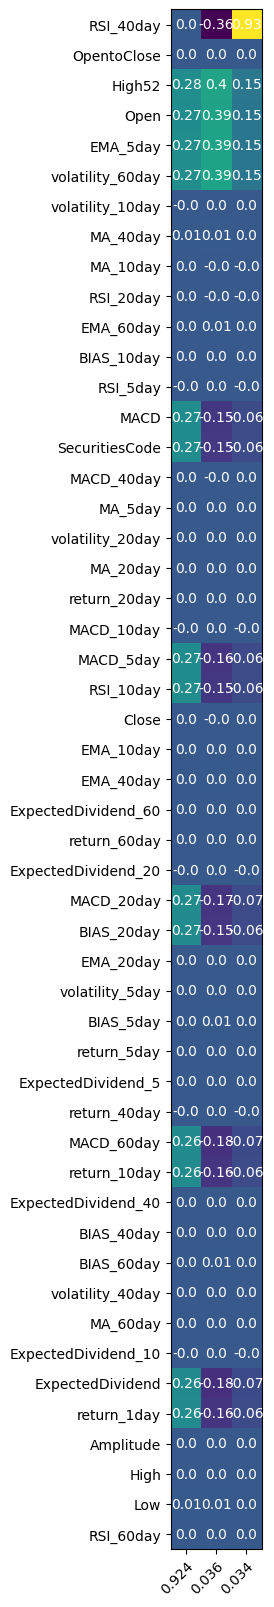

In [ ]:
fig, ax = plt.subplots()
selected_comp = pca.components_[:3]
heatmap = ax.imshow(selected_comp.transpose())
ax.set_yticks(np.arange(len(original_features)), labels=original_features)
ax.set_xticks(np.arange(selected_comp.shape[0]), labels=pca.explained_variance_ratio_[:3])
ax.set_xticklabels([f"{var:.3f}" for var in pca.explained_variance_ratio_[:3]])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


for f in np.arange(len(original_features)):
    for c in np.arange(selected_comp.shape[0]):
        ax.text(c, f, np.round(selected_comp[c, f], 2),
                       ha="center", va="center", color="white")

fig.set_size_inches(20, 20)

Save as dataframe

In [ ]:
pca_df = pd.DataFrame(pca.components_)
pca_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,4.671353e-03,0.000011,2.756455e-01,2.692694e-01,2.725316e-01,2.724540e-01,-1.280084e-09,6.376063e-03,7.766764e-05,3.108249e-08,...,0.004341,2.408646e-07,9.516332e-07,-1.865238e-08,2.581985e-01,0.262407,1.102230e-05,0.000045,6.416093e-03,4.094952e-07
1,-3.590921e-01,0.000009,3.974966e-01,3.850009e-01,3.910380e-01,3.914245e-01,2.656475e-07,1.249563e-02,-3.865054e-04,-3.021206e-05,...,0.005654,3.804505e-06,8.380976e-06,2.267044e-07,-1.786168e-01,-0.163141,8.140533e-06,0.000382,5.314351e-03,4.761855e-06
2,9.332870e-01,0.000007,1.508895e-01,1.474427e-01,1.490784e-01,1.492585e-01,7.257443e-08,3.446810e-03,-1.800826e-04,-8.704827e-06,...,0.001606,9.607560e-07,1.010882e-06,-2.428157e-07,-7.102252e-02,-0.063224,6.746583e-06,0.000076,1.118087e-03,1.092123e-06
3,-1.474051e-03,0.000006,-1.622287e-02,-1.768674e-02,-1.734805e-02,-1.630069e-02,2.587299e-07,1.463872e-03,-1.047357e-03,-6.772233e-05,...,0.041691,1.778159e-05,3.091025e-05,-3.232678e-06,-7.015455e-01,0.135063,6.244703e-06,0.001416,3.073102e-02,2.156440e-05
4,-1.213352e-03,0.000003,-2.749989e-03,1.293488e-02,5.666542e-03,3.787738e-03,-5.529973e-07,-1.568487e-02,1.878804e-03,-1.508291e-07,...,-0.242019,-5.833679e-05,-1.552734e-04,-1.596596e-06,2.262248e-01,0.472844,3.004635e-06,-0.007611,-2.396979e-01,-8.195542e-05
5,-4.246577e-04,0.000228,-2.471253e-03,1.654796e-02,1.037256e-02,2.845626e-03,-1.990091e-06,-1.901921e-02,7.526933e-03,-6.364268e-05,...,-0.193809,-7.230212e-05,-1.349005e-04,-3.719715e-06,-5.112665e-01,0.248538,2.280825e-04,-0.006553,-1.989932e-01,-8.889891e-05
6,3.129535e-04,0.000105,8.095972e-03,-1.377029e-02,-6.541577e-03,6.327806e-04,1.057628e-06,2.186626e-02,-7.174358e-03,-3.916818e-05,...,0.200474,1.904399e-05,1.059843e-04,-5.031926e-07,-2.781049e-01,-0.072811,1.052889e-04,0.002730,2.426967e-01,3.607345e-05
7,4.833496e-04,-0.000255,2.140715e-02,-2.495326e-02,4.714619e-03,-8.024356e-03,-2.295461e-06,4.636041e-02,1.273897e-02,-4.667583e-05,...,0.299309,-3.828779e-05,8.643276e-05,9.846686e-07,1.182421e-01,-0.016673,-2.552397e-04,-0.001422,4.159962e-01,-9.661844e-06
8,4.550990e-04,-0.000178,2.989259e-02,-2.877656e-02,2.906015e-02,-2.904248e-02,-1.090392e-05,5.866916e-02,5.810263e-02,-1.172836e-04,...,0.235294,-1.296815e-04,-2.989168e-05,1.802762e-07,2.690831e-03,0.079657,-1.785791e-04,-0.009077,4.408058e-01,-1.137863e-04
9,-2.911053e-04,0.000021,-3.601361e-02,3.676160e-02,-4.700371e-02,4.797348e-02,1.456242e-05,-7.277521e-02,-9.497719e-02,8.976365e-05,...,-0.082029,9.524247e-05,6.746339e-05,-1.149532e-06,4.684148e-03,-0.077117,2.083562e-05,0.005557,-2.663336e-01,9.767358e-05


Feature Subset Selection.

In [ ]:
display(feature.describe())

,SecuritiesCode,ExpectedDividend,High,Low,Open,Close,return_1day,Amplitude,OpentoClose,High52,...,MACD_40day,BIAS_40day,return_60day,volatility_60day,MA_60day,EMA_60day,ExpectedDividend_60,RSI_60day,MACD_60day,BIAS_60day
count,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,...,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06,2.332531e+06
mean,5.894835e+03,1.780746e-01,2.617973e+03,2.552873e+03,2.586048e+03,2.585563e+03,4.298879e-04,6.509961e+01,4.857468e-01,4.328090e-01,...,1.272342e+01,4.930561e-03,2.615512e-02,2.011008e-02,2.333074e+03,2.440906e+03,1.776489e-01,5.055024e+01,1.817887e+01,7.122631e-03
std,2.404161e+03,3.333284e+00,3.616558e+03,3.530748e+03,3.574416e+03,3.573763e+03,2.338437e-02,1.165951e+02,8.290900e+01,6.091219e-01,...,1.639753e+02,8.243801e-02,1.868498e-01,1.050045e-02,3.333250e+03,3.333058e+03,3.320364e+00,9.110288e+00,1.980318e+02,9.989700e-02
min,1.301000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.785414e-01,0.000000e+00,-1.210000e+04,0.000000e+00,...,-8.963698e+03,-7.858142e-01,-8.328373e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.391327e+03,-7.945790e-01
25%,3.891000e+03,0.000000e+00,1.029000e+03,1.003000e+03,1.016000e+03,1.015000e+03,-1.048951e-02,1.900000e+01,-1.400000e+01,0.000000e+00,...,-2.646858e+01,-3.556935e-02,-7.100127e-02,1.391423e-02,9.217500e+02,1.013758e+03,0.000000e+00,4.503755e+01,-3.132470e+01,-4.239131e-02
50%,6.238000e+03,0.000000e+00,1.828000e+03,1.784000e+03,1.806000e+03,1.806000e+03,0.000000e+00,3.700000e+01,0.000000e+00,4.315145e-01,...,1.582749e+00,1.698493e-04,0.000000e+00,1.851065e-02,1.659383e+03,1.734073e+03,0.000000e+00,5.033838e+01,2.125779e+00,0.000000e+00
75%,7.965000e+03,0.000000e+00,3.060000e+03,2.990000e+03,3.025000e+03,3.025000e+03,1.049233e-02,7.200000e+01,1.500000e+01,7.905759e-01,...,3.727929e+01,4.239734e-02,9.960159e-02,2.504136e-02,2.776533e+03,2.845954e+03,0.000000e+00,5.599990e+01,4.575156e+01,5.173286e-02
max,9.997000e+03,1.070000e+03,1.105000e+05,1.072000e+05,1.099500e+05,1.095500e+05,1.119512e+00,1.510000e+04,1.400000e+04,2.000000e+01,...,9.422248e+03,2.541667e+00,6.236923e+00,1.225336e-01,9.447217e+04,9.389482e+04,1.070000e+03,1.000000e+02,1.050899e+04,2.841430e+00
